# Import Packages

In [1]:
# import packages

import collections
import math
import matplotlib.pyplot as pp
import numpy as np
import tslearn.utils
import pandas as pd
import yfinance as yf
from collections import deque
from copy  import deepcopy
from datetime import datetime, timedelta
from fastdtw import fastdtw
import glob
from itertools import islice
from IPython.display import display
from math import sqrt
from matplotlib.pyplot import figure
from pandas import DataFrame
from pandas_datareader import data as pdr
from pytrends.request import TrendReq
from scipy.stats import ttest_1samp
from scipy import stats
from scipy.spatial.distance import euclidean
from scipy.stats import ttest_1samp
from scipy.stats.mstats import winsorize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from statsmodels.formula.api import ols
from statsmodels.tsa.stattools import adfuller
from tslearn.clustering import TimeSeriesKMeans
from tslearn.utils import to_time_series
import yfinance as yf

%matplotlib inline

# Data Pre-processing

## Config View

In [2]:
# set maximum viewing window (personal preference)
pd.set_option('display.max_rows', 500)

# Sentiment Analysis - Google

## Configurations

### Lists of Keywords:
- **Recession**
- **Finanial Crisis**
- **Market Crash**
- **Economy**

**This keywords are tested and handpicked**

These terms are also tested but not included due to either too general or too specfic.
- Disaster
- Crisis
- Covid
- Pandemic

After some experiment, it was decided to leave the list simple and general. Since a worldwide crisis can come in many forms with new terms are often developed to describe them, for example 'Covid'. This made targeting it very difficult if not impossible. Additionally, a post-crisis environment can be very subjective and is not very well defined. This method uses the 2008 GFC as a benchmark. Terms like 'death', depression', 'world war', etc are excluded due to wide usage causing unexpected results. Terms associated with natural disasters often led to results that are too 'regional' hence also excluded.

In [3]:
# Configure Keywords
keywords = ['Recession', 'Financial Crisis', 'Market Crash', 'Economy']

# NOTE: Search terms reference Irresberger et al. (2015) [4 keywords]; Anastasious & Drakos (2021) [p119-p120 in particular] --> irrational choices

# Tempo Array (apply this when search terms <= 5)
# keyword = []

In [4]:
# Configure search period
start_end = '2007-02-26 2021-03-20'

In [5]:
# Configure other parameters
timeframe = start_end
cat = '16' # News = 16 (Google ID)
geo = 'US' # US for America
gprop = '' # Google property filter

In [6]:
# Config package (Needed for the package to run properly)
pytrends = TrendReq(hl = 'en-US')

## Define Functions

In [7]:
# Define Search Function
def search_trends():
    pytrends.build_payload(keywords, cat, timeframe, geo, gprop)
    data = pytrends.interest_over_time()
    return data

In [8]:
# Iteration Search for when keywords >= 5
# for kw in keywords:
#     keyword.append(kw)
#     search_trends()
#     keywords.pop()

In [9]:
# Define Function to check critical values, this function only prints informative values
def check_crisis(data):
    for kw in keywords:
        mean = round(data[kw].mean(), 2)
        avg_12 = round(data[kw][-12:].mean(),2)
        avg_L5 = round(data[kw][-60:].mean(),2)
        avg2008 = round(data[data.index.year == 2008][kw].mean(), 2)
        print(kw + ' all time mean: ' + str(mean))
        print(kw + ' last year mean: ' + str(avg_12))
        print(kw + ' last 5 year mean: ' + str(avg_L5))
        print(kw + ' 2008 mean: ' + str(avg2008))

In [10]:
# Define Function for FEARS Index Part 1
def fearsindex_df(data):
    pp.figure(figsize=(20,10))
    data1 = data.copy(deep=True)
    data1['t'] = np.arange(start = 1, stop = len(data1) + 1) ### Step2 prep. set time-series index t
    mon_dum = pd.get_dummies(data1.index.month, prefix = 'Month').iloc[:, 1:] ### Step2 prep. Get monthly Dummies 
    data1 = pd.concat([data1, mon_dum.set_index(data1.index)], axis = 1) ### Step2 prep. Put Dummies into Table
    for kw in keywords:
        col_name1 = kw + '_deltaGSVI'
        col_name2 = kw + '_deltaGSVI_residual'
        col_name3 = kw + '_Adjusted_deltaGSVI'
        ### Compute the FEARS Index
        data1[kw] = winsorize(data1[kw], limits=[0.025, 0.025]) ### Step1. winsorize 95-percent
        data1[col_name1] = np.log(data1[kw]) - np.log(data1[kw].shift(1)) ### Step2a. Compute deltaAGSVI(i,t) - weekly log change
        data1[col_name1] = data1[col_name1].fillna(0)
        fit = ols('data1[col_name1] ~ t + C(Month_2) + C(Month_3) + C(Month_4) + C(Month_5) + C(Month_6) + C(Month_7) + C(Month_8) + C(Month_9) + C(Month_10) + C(Month_11) + C(Month_12)', data = data1).fit() ### Step2b. linear regression on monthly dummies
        data1[col_name2] = fit.resid ### Step2c. retrive the residual
        ### Step3. scale by standard deviation
        ### Attribute: https://machinelearningmastery.com/normalize-standardize-time-series-data-python/
        ### Author: Jason Brownlee
        temp = data1[col_name2].values.reshape(-1,1)
        scaler = StandardScaler()
        scaler = scaler.fit(temp)
        print('Mean: %f, StandardDeviation: %f' % (scaler.mean_, sqrt(scaler.var_)))
        data1[col_name3] = scaler.transform(temp)
        ### Plot some graph for visualisation
        fig, ax1 = pp.subplots()
        color = 'tab:blue'
        ax1.set_ylabel('Google Search Index', color = 'blue')
        ax1.plot(data1.index.values, data1[kw]) 
        ax1.tick_params(axis ='y', labelcolor = 'blue') 
        ax2 = ax1.twinx() 
        color = 'tab:red'
        ax2.set_ylabel('Adjusted Delta GSVI', color = 'red') 
        ax2.plot(data1.index.values, data1[col_name3], color = 'red') 
        ax2.tick_params(axis ='y', labelcolor = 'red') 
        pp.title(kw + ' GSVI and Adjusted Delta AGSVI')
        pp.show()
    return data1

In [11]:
# Define Function for FEARS Index Part 1
def fears(data):
    data2 = data.copy(deep=True)
    for i in range (len(data2)):
        agg = []
        for kw in keywords:
            col_name3 = kw + '_Adjusted_deltaGSVI'
            agg.append(data2[col_name3])
        newval = sum(agg)/len(agg)
        data2['FEARS_Index'] = newval
    pp.figure(figsize=(20,10))
    ### lot some graph for visualisation
    pp.plot(data2.index.values, data2['FEARS_Index'], label='FEARS Index')
    pp.legend(loc='best')
    pp.title('Evolution of FEARS Index.')
    pp.show()
    return data2
    
# A simplified version of the FEAR index is introduced to speed up the process, with the major change been reduced
# number of search terms (from 118 (the original Da et al. study) or 30 (Irresberger et al. follow-up study) to 4.)

In [12]:
# Define the Threshold and Range for FEARS Index
def crisis(fears_data):
    data3 = fears_data.copy(deep=True)
    threshold_G = 1
    crisis = np.where(data1['FEARS_Index'] > threshold_G)
    crisis_data = data1.iloc[crisis]
    crisis_data.index
    crisis_period_start = crisis_data.index - timedelta(weeks = 52)
    crisis_period_end = crisis_data.index + timedelta(weeks = 104)
    crisis_period = pd.DataFrame(data = list(zip(crisis_data.index, crisis_period_start, crisis_period_end)))
    crisis_period = crisis_period.rename({0: 'Crisis Date', 1: 'Start', 2: 'End'}, axis='columns')
    ### lot some graph for visualisation
    for crisis_period_start, crisis_period_end in zip(crisis_period_start, crisis_period_end):
        pp.axvspan(crisis_period_start, crisis_period_end, color = 'red', alpha = 0.5)
        pp.plot(fears_data.index.values, fears_data['FEARS_Index'], label='FEARS Index')
        pp.legend(loc='best')
        pp.title('Evolution of FEARS Index with Identified Crisis Period Highlighted')
        pp.show()
    return crisis_period

## Perform Search

In [13]:
# Save data in memory
dt = search_trends()

In [14]:
# Check if data has been downloaded correctly
pd.set_option('display.max_rows', 500)
print(dt.index)
dt

DatetimeIndex(['2007-03-01', '2007-04-01', '2007-05-01', '2007-06-01',
               '2007-07-01', '2007-08-01', '2007-09-01', '2007-10-01',
               '2007-11-01', '2007-12-01',
               ...
               '2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01',
               '2020-10-01', '2020-11-01', '2020-12-01', '2021-01-01',
               '2021-02-01', '2021-03-01'],
              dtype='datetime64[ns]', name='date', length=169, freq=None)


,Recession,Financial Crisis,Market Crash,Economy,isPartial
date,,,,,
2007-03-01,9,2,12,19,False
2007-04-01,5,2,6,19,False
2007-05-01,4,1,9,21,False
2007-06-01,3,0,3,12,False
2007-07-01,2,1,4,9,False
2007-08-01,11,2,5,12,False
2007-09-01,18,1,7,19,False
2007-10-01,14,1,10,20,False
2007-11-01,21,2,7,22,False


In [15]:
# Check the basic information
check_crisis(dt)

Recession all time mean: 15.18
Recession last year mean: 13.17
Recession last 5 year mean: 13.45
Recession 2008 mean: 42.92
Financial Crisis all time mean: 4.78
Financial Crisis last year mean: 2.25
Financial Crisis last 5 year mean: 3.0
Financial Crisis 2008 mean: 10.75
Market Crash all time mean: 7.25
Market Crash last year mean: 11.17
Market Crash last 5 year mean: 9.02
Market Crash 2008 mean: 11.25
Economy all time mean: 20.85
Economy last year mean: 18.75
Economy last 5 year mean: 17.03
Economy 2008 mean: 45.67


Mean: 0.000000, StandardDeviation: 0.319139


<Figure size 1440x720 with 0 Axes>

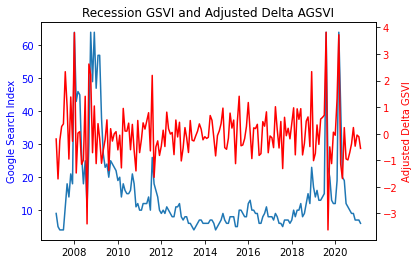

Mean: 0.000000, StandardDeviation: 0.362335


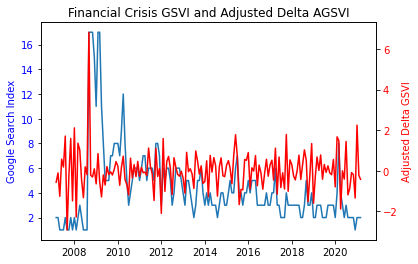

Mean: -0.000000, StandardDeviation: 0.442276


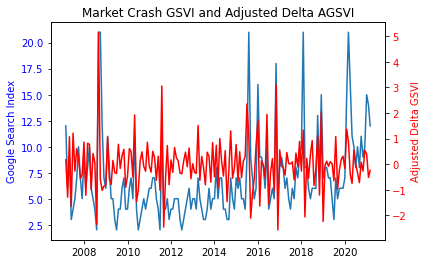

Mean: 0.000000, StandardDeviation: 0.158684


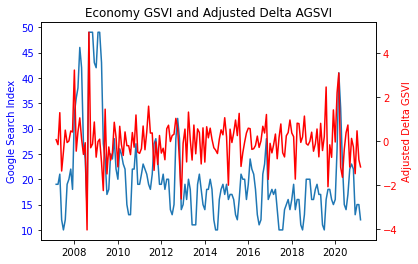

In [16]:
# Apply fearsindex() function to compute all values required to calculate the fears index
data1 = fearsindex_df(dt)

In [17]:
# Check if the table has the correct format (Beware It gonna be a Large Table!)
pd.set_option('display.max_columns', None)
data1

,Recession,Financial Crisis,Market Crash,Economy,isPartial,t,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,Recession_deltaGSVI,Recession_deltaGSVI_residual,Recession_Adjusted_deltaGSVI,Financial Crisis_deltaGSVI,Financial Crisis_deltaGSVI_residual,Financial Crisis_Adjusted_deltaGSVI,Market Crash_deltaGSVI,Market Crash_deltaGSVI_residual,Market Crash_Adjusted_deltaGSVI,Economy_deltaGSVI,Economy_deltaGSVI_residual,Economy_Adjusted_deltaGSVI
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2007-03-01,9,2,12,19,False,1,0,1,0,0,0,0,0,0,0,0,0,0.000000,-0.063848,-0.200063,0.000000,-0.205410,-0.566908,0.000000,0.077063,0.174241,0.000000,0.008024,0.050566
2007-04-01,5,2,6,19,False,2,0,0,1,0,0,0,0,0,0,0,0,-0.587787,-0.544305,-1.705539,0.000000,-0.040066,-0.110576,-0.693147,-0.570581,-1.290101,0.000000,-0.027683,-0.174456
2007-05-01,4,1,9,21,False,3,0,0,0,1,0,0,0,0,0,0,0,-0.223144,-0.082910,-0.259792,-0.693147,-0.456951,-1.261130,0.405465,0.475028,1.074054,0.100083,0.202907,1.278684
2007-06-01,4,1,3,12,False,4,0,0,0,0,1,0,0,0,0,0,0,0.000000,0.086004,0.269487,0.000000,0.207049,0.571429,-1.098612,-0.729247,-1.648850,-0.559616,-0.217577,-1.371131
2007-07-01,4,1,4,10,False,5,0,0,0,0,0,1,0,0,0,0,0,0.000000,0.117625,0.368569,0.000000,0.066361,0.183149,0.287682,0.536871,1.213883,-0.182322,-0.080187,-0.505324
2007-08-01,11,2,5,12,False,6,0,0,0,0,0,0,1,0,0,0,0,1.011601,0.744916,2.334140,0.693147,0.617947,1.705459,0.223144,-0.120382,-0.272187,0.182322,0.077013,0.485321
2007-09-01,18,1,7,19,False,7,0,0,0,0,0,0,0,1,0,0,0,0.492476,0.323485,1.013615,-0.693147,-1.057384,-2.918253,0.336472,0.269026,0.608276,0.459532,-0.012517,-0.078882
2007-10-01,14,1,10,20,False,8,0,0,0,0,0,0,0,0,1,0,0,-0.251314,-0.305520,-0.957326,0.000000,-0.084183,-0.232334,0.356675,0.100718,0.227728,0.051293,-0.000795,-0.005008
2007-11-01,21,2,7,22,False,9,0,0,0,0,0,0,0,0,0,1,0,0.405465,0.440919,1.381588,0.693147,0.575962,1.589586,-0.356675,-0.248199,-0.561185,0.095310,0.070962,0.447191


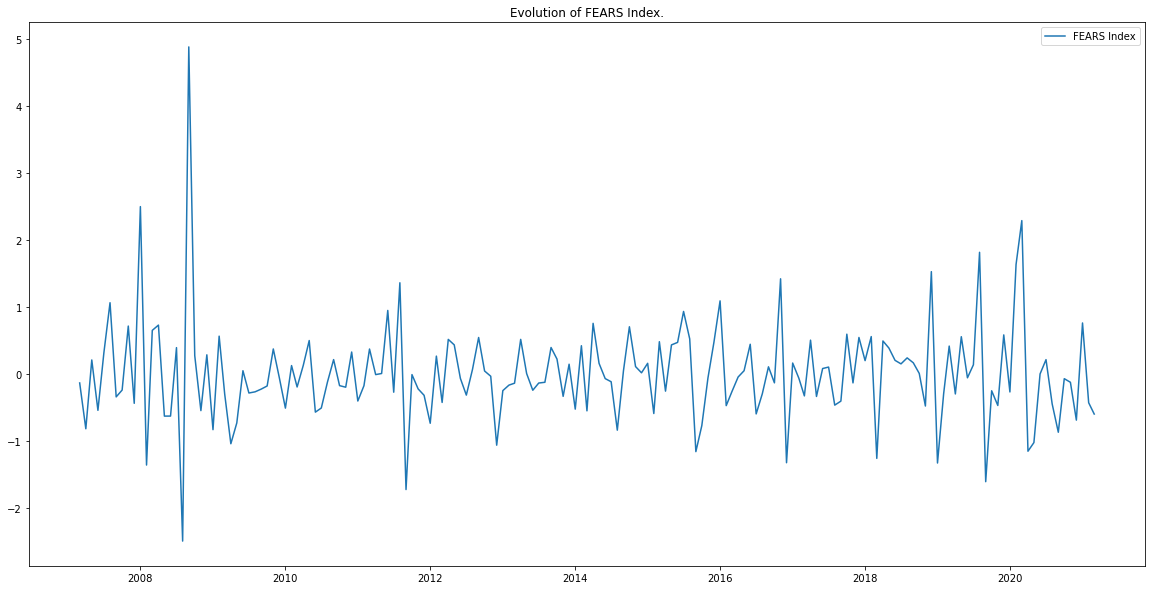

In [18]:
data1 = fears(data1)

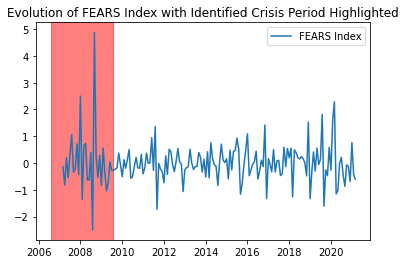

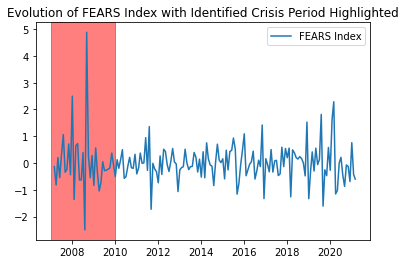

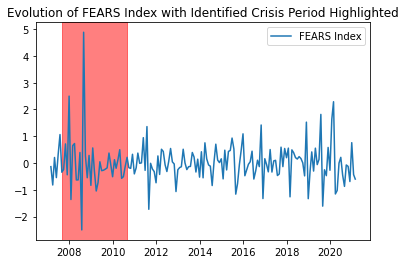

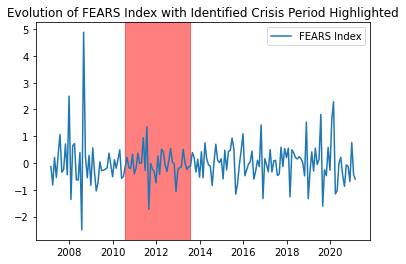

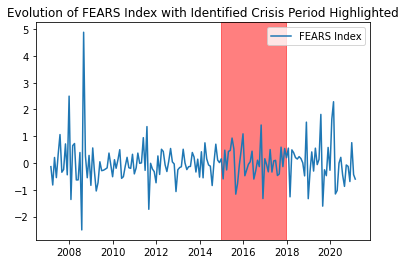

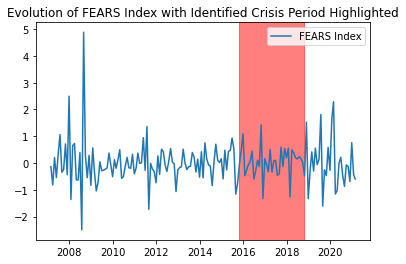

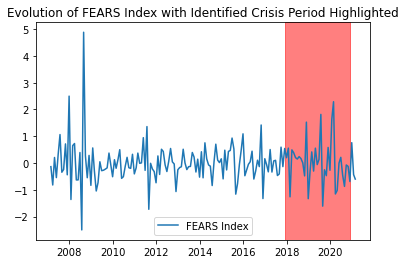

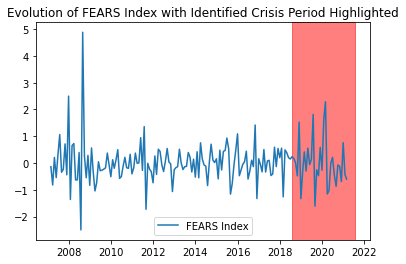

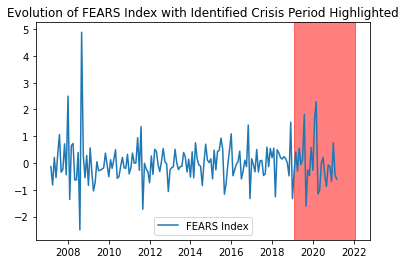

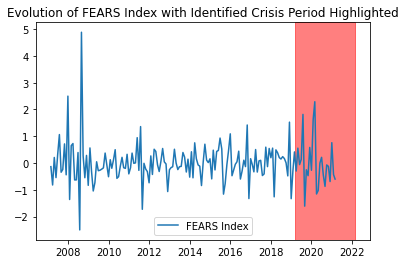

In [19]:
crisis_period = crisis(data1)

In [20]:
# Check if the table has the correct format 
crisis_period

,Crisis Date,Start,End
0,2007-08-01,2006-08-02,2009-07-29
1,2008-01-01,2007-01-02,2009-12-29
2,2008-09-01,2007-09-03,2010-08-30
3,2011-08-01,2010-08-02,2013-07-29
4,2016-01-01,2015-01-02,2017-12-29
5,2016-11-01,2015-11-03,2018-10-30
6,2018-12-01,2017-12-02,2020-11-28
7,2019-08-01,2018-08-02,2021-07-29
8,2020-02-01,2019-02-02,2022-01-29
9,2020-03-01,2019-03-03,2022-02-27


# Sentiment Analysis - Reddit

## Detection Formula

In [21]:
# Define the Hypothesis Function
def HTS(array1, array2): ### ref: reference window, det: detection window
    ref = array1
    det = array2 ### These two lines are reserved for easy change to a different HT function.
    tset, pval = stats.ttest_ind(det, ref)
    return pval

In [22]:
# Define the Anomaly Detection Function.
def FindAnomaly_S(GME_count_Reddit, size = 5): ### size: window size (default = 5)
    if len(GME_count_Reddit) < size:
        print("Not enough data.")
    else:
        for i in range(len(GME_count_Reddit)-(2*size-1)):
            ref_W = GME_count_Reddit['Count'][i:i+size]
            det_W = GME_count_Reddit['Count'][i+size:i+2*size]
            print("Date:", GME_count_Reddit['Date'][i+size]) ###
            pval = HTS(ref_W, det_W)
            print("The p-value is:", pval)
            if pval < 0.05:
                print("Anomaly Pattern Detected!!!!!")
            else:
                print("No Anomlay Detected.")

In [23]:
# Define the Record Anomaly Function. (This function will store all the anomalies into a dataframe)
def RecordAnomaly_S(GME_count_Reddit, vr, size):
    anomaly = {'Date':[], 
               vr:[]}
    if len(GME_count_Reddit) < size+5:
        print("Not enough data.")
    else:
        for i in range(len(GME_count_Reddit)-(2*size-1)):
            ref_W = GME_count_Reddit['Count'][i:i+size]
            det_W = GME_count_Reddit['Count'][i+size:i+2*size]
            pval = HTS(ref_W, det_W)
            if pval < 0.05:
                anomaly['Date'].append(GME_count_Reddit['Date'][i+size]) ###
                anomaly[vr].append(GME_count_Reddit['Count'][i+size]) ###
    return anomaly

## Compute Volume of Sentiments

In [24]:
# Dataframe Display Configuration
pd.set_option('display.max_rows', 500)

# IMPORTANT: Change REDDIT Sentiment INPUT Here

In [245]:
# Read the Combined Data
R_sen = pd.read_excel(r'Data\Reddit_NOKIA_sentiments.xlsx')
# R_sen = pd.read_csv(r'Data\Reddit_GME_Sentiments.csv') ### Use this one for CSV files

# #################################

In [246]:
# Convert Date to datetime Format
R_sen['Date'] = pd.to_datetime(R_sen['Date'])

In [247]:
R_sen

,created_utc,title,url,Date
0,1614474077,$VISL $TRCH $NOK $ITRM,https://www.reddit.com/r/wallstreetbets/commen...,2021-02-28 01:01:17
1,1614458109,https://www.nokia.com/about-us/news/releases/2...,https://www.reddit.com/r/wallstreetbets/commen...,2021-02-27 20:35:09
2,1614458025,Nokia is literally GOING TO THE MOON!! Let’s s...,https://www.reddit.com/r/wallstreetbets/commen...,2021-02-27 20:33:45
3,1614452740,Nok 🚀🚀🚀,https://www.reddit.com/r/wallstreetbets/commen...,2021-02-27 19:05:40
4,1614448885,What's up with Nokia there 3.92 a share could ...,https://www.reddit.com/r/wallstreetbets/commen...,2021-02-27 18:01:25
...,...,...,...,...
27968,1569418657,Morning Briefing (9/25/2019),https://www.reddit.com/r/wallstreetbets/commen...,2019-09-25 13:37:37
27969,1569250041,$NOK calls will do well,https://www.reddit.com/r/wallstreetbets/commen...,2019-09-23 14:47:21
27970,1569244344,Morning Briefing (9/23/2019),https://www.reddit.com/r/wallstreetbets/commen...,2019-09-23 13:12:24
27971,1568643027,Morning Briefing (9/16/2019),https://www.reddit.com/r/wallstreetbets/commen...,2019-09-16 14:10:27


In [248]:
# Delete Duplicate
R_sen.drop_duplicates(subset = ["title", "url"], keep = False, inplace = True)

In [249]:
# Check Data
R_sen

,created_utc,title,url,Date
0,1614474077,$VISL $TRCH $NOK $ITRM,https://www.reddit.com/r/wallstreetbets/commen...,2021-02-28 01:01:17
1,1614458109,https://www.nokia.com/about-us/news/releases/2...,https://www.reddit.com/r/wallstreetbets/commen...,2021-02-27 20:35:09
2,1614458025,Nokia is literally GOING TO THE MOON!! Let’s s...,https://www.reddit.com/r/wallstreetbets/commen...,2021-02-27 20:33:45
3,1614452740,Nok 🚀🚀🚀,https://www.reddit.com/r/wallstreetbets/commen...,2021-02-27 19:05:40
4,1614448885,What's up with Nokia there 3.92 a share could ...,https://www.reddit.com/r/wallstreetbets/commen...,2021-02-27 18:01:25
...,...,...,...,...
27968,1569418657,Morning Briefing (9/25/2019),https://www.reddit.com/r/wallstreetbets/commen...,2019-09-25 13:37:37
27969,1569250041,$NOK calls will do well,https://www.reddit.com/r/wallstreetbets/commen...,2019-09-23 14:47:21
27970,1569244344,Morning Briefing (9/23/2019),https://www.reddit.com/r/wallstreetbets/commen...,2019-09-23 13:12:24
27971,1568643027,Morning Briefing (9/16/2019),https://www.reddit.com/r/wallstreetbets/commen...,2019-09-16 14:10:27


In [250]:
# Sort by Date
R_sen = R_sen.sort_values('Date')

In [251]:
# Keep the Columns needed and Reset Index
R_sen_sort = R_sen[['Date', 'title', 'url']].reset_index()
del R_sen_sort['index']

In [252]:
# Rename the column names to 
R_sen_sort.rename(columns={"title": "Title"})

,Date,Title,url
0,2019-09-03 13:13:41,Morning Briefing (9/3/2019),https://www.reddit.com/r/wallstreetbets/commen...
1,2019-09-16 14:10:27,Morning Briefing (9/16/2019),https://www.reddit.com/r/wallstreetbets/commen...
2,2019-09-23 13:12:24,Morning Briefing (9/23/2019),https://www.reddit.com/r/wallstreetbets/commen...
3,2019-09-23 14:47:21,$NOK calls will do well,https://www.reddit.com/r/wallstreetbets/commen...
4,2019-09-25 13:37:37,Morning Briefing (9/25/2019),https://www.reddit.com/r/wallstreetbets/commen...
...,...,...,...
27954,2021-02-27 18:01:25,What's up with Nokia there 3.92 a share could ...,https://www.reddit.com/r/wallstreetbets/commen...
27955,2021-02-27 19:05:40,Nok 🚀🚀🚀,https://www.reddit.com/r/wallstreetbets/commen...
27956,2021-02-27 20:33:45,Nokia is literally GOING TO THE MOON!! Let’s s...,https://www.reddit.com/r/wallstreetbets/commen...
27957,2021-02-27 20:35:09,https://www.nokia.com/about-us/news/releases/2...,https://www.reddit.com/r/wallstreetbets/commen...


In [253]:
# Count Posts Group By Dates
# Attribute: https://stackoverflow.com/questions/52182967/python-pandas-group-by-date-and-count
# Author: jezrael

R_count_Reddit = R_sen_sort['Date'].dt.date.value_counts().sort_index().reset_index()

In [254]:
# Rename Dataframe
R_count_Reddit = R_count_Reddit.rename(columns={"index": "Date", "Date": "Count"})

In [255]:
# Remove Extra Data Points
R_count_Reddit['Date'] = pd.to_datetime(R_count_Reddit['Date'])
R_count_Reddit = R_count_Reddit[~(R_count_Reddit['Date'] > '2021-02-11')]

In [256]:
# Log Convertion
R_count_Reddit['Log Count'] = np.log(R_count_Reddit['Count'])

Text(0.5, 1.0, 'Daily Count of Related Posts in r/WallStreetBets')

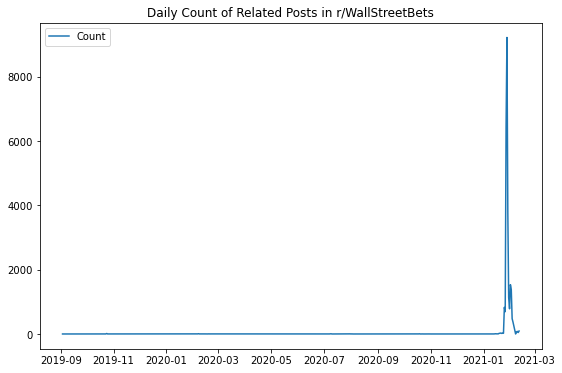

In [257]:
# Visulisation
pp.figure(figsize=(9,6))
pp.plot(R_count_Reddit.Date, R_count_Reddit.Count, label = 'Count')
pp.legend(loc = 'best')
pp.title('Daily Count of Related Posts in r/WallStreetBets')

In [258]:
# Run the Detection Method
FindAnomaly_S(R_count_Reddit)

Date: 2019-10-08 00:00:00
The p-value is: 0.6665811073830707
No Anomlay Detected.
Date: 2019-10-15 00:00:00
The p-value is: 0.3972038407802937
No Anomlay Detected.
Date: 2019-10-19 00:00:00
The p-value is: 0.27183691332185733
No Anomlay Detected.
Date: 2019-10-21 00:00:00
The p-value is: 0.21440640986369505
No Anomlay Detected.
Date: 2019-10-22 00:00:00
The p-value is: 0.29948989697842365
No Anomlay Detected.
Date: 2019-10-23 00:00:00
The p-value is: 0.26370362272317677
No Anomlay Detected.
Date: 2019-10-24 00:00:00
The p-value is: 0.32872042455250955
No Anomlay Detected.
Date: 2019-10-25 00:00:00
The p-value is: 0.32872042455250955
No Anomlay Detected.
Date: 2019-10-26 00:00:00
The p-value is: 0.26370362272317677
No Anomlay Detected.
Date: 2019-10-28 00:00:00
The p-value is: 0.26915310688181554
No Anomlay Detected.
Date: 2019-10-29 00:00:00
The p-value is: 0.21178265210422756
No Anomlay Detected.
Date: 2019-10-30 00:00:00
The p-value is: 0.24309463562888134
No Anomlay Detected.
Date: 

In [259]:
# Record Unusual Investor Attention
R_Anomaly = RecordAnomaly_S(R_count_Reddit, "Unusual Investor Attention", 5)
Reddit_Anomaly = pd.DataFrame(R_Anomaly)
display(Reddit_Anomaly)

,Date,Unusual Investor Attention
0,2019-11-03,1
1,2020-03-07,1
2,2020-05-30,1
3,2020-06-01,2
4,2020-07-22,2
5,2020-07-28,2
6,2020-08-03,1
7,2020-10-17,3
8,2020-12-13,1
9,2021-01-13,2


# Sentiment Analysis - Twitter

# IMPORTANT: Change TWITTER Sentiment INPUT Here

In [260]:
# Read the Combined Data (AMC & GME has Part 1 & 2)
# sen_T1 = pd.read_csv(r'Data\AMC_Twitter_Part1.csv') ###
# sen_T2 = pd.read_csv(r'Data\AMC_Twitter_Part2.csv') ###
# sen_T = sen_T1.append(sen_T2, ignore_index=True)

sen_T = pd.read_csv(r'Data\NOK_Twitter.csv') ###

# #################################

In [261]:
# Convert Date to datetime Format
sen_T['Date'] = pd.to_datetime(sen_T['Date'])

In [262]:
# Remove Extra Data Points
sen_T['Date'] = pd.to_datetime(sen_T['Date'])
sen_T = sen_T[~(sen_T['Date'] > '2021-02-11')]

In [263]:
# Rename Dataframe
sen_T = sen_T.rename(columns={"Frequency": "Count"})

In [264]:
sen_T

,Date,Count
0,2019-08-02,2
1,2019-08-03,1
2,2019-08-04,0
3,2019-08-05,1
4,2019-08-06,7
...,...,...
555,2021-02-07,113
556,2021-02-08,266
557,2021-02-09,223
558,2021-02-10,229


Text(0.5, 1.0, 'Daily Count of Related Tweets on Twitter')

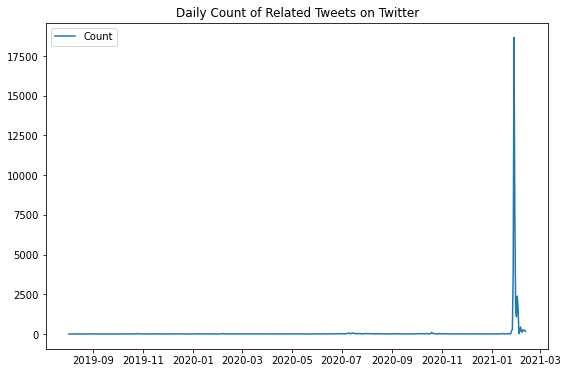

In [265]:
# Visulisation
pp.figure(figsize=(9,6))
pp.plot(sen_T.Date, sen_T.Count, label = 'Count')
pp.legend(loc = 'best')
pp.title('Daily Count of Related Tweets on Twitter')

In [266]:
# Run the Detection Method
FindAnomaly_S(sen_T)

Date: 2019-08-07 00:00:00
The p-value is: 0.5959933066795502
No Anomlay Detected.
Date: 2019-08-08 00:00:00
The p-value is: 0.6937998380169583
No Anomlay Detected.
Date: 2019-08-09 00:00:00
The p-value is: 1.0
No Anomlay Detected.
Date: 2019-08-10 00:00:00
The p-value is: 0.78342440625
No Anomlay Detected.
Date: 2019-08-11 00:00:00
The p-value is: 0.8893740251728112
No Anomlay Detected.
Date: 2019-08-12 00:00:00
The p-value is: 0.6195437484575322
No Anomlay Detected.
Date: 2019-08-13 00:00:00
The p-value is: 0.8195856784525776
No Anomlay Detected.
Date: 2019-08-14 00:00:00
The p-value is: 0.4875996168424147
No Anomlay Detected.
Date: 2019-08-15 00:00:00
The p-value is: 0.6665811073830705
No Anomlay Detected.
Date: 2019-08-16 00:00:00
The p-value is: 0.225571973816597
No Anomlay Detected.
Date: 2019-08-17 00:00:00
The p-value is: 0.20730483995919904
No Anomlay Detected.
Date: 2019-08-18 00:00:00
The p-value is: 0.5447373008044909
No Anomlay Detected.
Date: 2019-08-19 00:00:00
The p-valu

The p-value is: 0.6064987175058222
No Anomlay Detected.
Date: 2020-06-13 00:00:00
The p-value is: 0.7055653672754866
No Anomlay Detected.
Date: 2020-06-14 00:00:00
The p-value is: 0.7851441816449173
No Anomlay Detected.
Date: 2020-06-15 00:00:00
The p-value is: 0.05457296479931162
No Anomlay Detected.
Date: 2020-06-16 00:00:00
The p-value is: 0.5621055003253019
No Anomlay Detected.
Date: 2020-06-17 00:00:00
The p-value is: 0.8896558685929383
No Anomlay Detected.
Date: 2020-06-18 00:00:00
The p-value is: 0.3908507350911137
No Anomlay Detected.
Date: 2020-06-19 00:00:00
The p-value is: 0.30404637035000276
No Anomlay Detected.
Date: 2020-06-20 00:00:00
The p-value is: 0.9208073056262048
No Anomlay Detected.
Date: 2020-06-21 00:00:00
The p-value is: 0.18227052242047403
No Anomlay Detected.
Date: 2020-06-22 00:00:00
The p-value is: 0.014390790371993754
Anomaly Pattern Detected!!!!!
Date: 2020-06-23 00:00:00
The p-value is: 0.000884475345807384
Anomaly Pattern Detected!!!!!
Date: 2020-06-24 

In [267]:
# Record Unusual Investor Attention
T_Anomaly = RecordAnomaly_S(sen_T, "Unusual Investor Attention", 5)
Twitter_Anomaly = pd.DataFrame(T_Anomaly)
display(Twitter_Anomaly)

,Date,Unusual Investor Attention
0,2019-10-08,4
1,2019-10-31,3
2,2019-11-02,2
3,2019-11-03,1
4,2019-12-21,0
5,2020-01-10,4
6,2020-01-11,1
7,2020-02-05,3
8,2020-02-06,22
9,2020-02-12,4


# Format Data

### Read from CSV

In [268]:
# define formating function
def format_csv(csv_title):
    df = pd.read_csv(csv_title, index_col = 'Date') ### data as index 
    df = df[['Adj Close']] ### drop all other columns
    df['Return'] = (df['Adj Close'] / df['Adj Close'].shift(1)) - 1 ### compute return
    df['Return'] = df['Return'].fillna(0) ### replace NaN with 0
    df.index = pd.to_datetime(df.index) ### datatype conversion
    return df

### Scrub from yfinance
- Hourly data cannot be downloaded via website hence

In [269]:
# Define Price Scrubbing function using yfinance
yf.pdr_override() ### somehow this is needed

def scrub(St, start, end, iv):
    data = pdr.get_data_yahoo(St, start, end, interval = iv)
    return data

In [270]:
# Set Parameters
St = "AMC" ### ["GME", "AMC", "BB", "NOK"]
start = "2020-10-01" ### format: yyyy-mm-dd (start date can only be max 730d from today for hourly data)
end = "2021-02-28" ### format: yyyy-mm-dd
iv = "1h" ### valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo

In [271]:
# Hourly Data has to be scrubbed using yfinance
# df = scrub(St, start, end, iv)

In [52]:
# Convert Index to be Saved
# didx = pd.to_datetime(df.index)
# df['Date'] = didx

In [53]:
# Check the data
# df = df[['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]

In [54]:
# Save Data
# df.to_csv(r'Data\AMC_hr.csv', index = False)

## Detrend & Smoothing

### Log Transformation & Detrend

In [55]:
# Attribute: https://github.com/srafay/Time-Series-Analysis-JetRail/blob/f5c25f4d481ddb8deaea09f2cff2d8585dcf6bb4/Jet_Rail.py#L197
# Author: Syed Rafay
# 2nd Attribute: Recommended & Reviewed by
# Author: Zhaolin

def test_stationarity(timeseries, w, title='Rolling Mean & Standard Deviation'): ### w: window size
    #Determing rolling statistics
    rolmean = timeseries.rolling(center=False,window=w).mean()
    rolstd = timeseries.rolling(center=False,window=w).std()
    #Plot rolling statistics:
    pp.figure(figsize=(20,10))
    orig = pp.plot(timeseries, color='blue',label='Original')
    mean = pp.plot(rolmean, color='red', label='Rolling Mean')
    std = pp.plot(rolstd, color='green', label = 'Rolling Std')
    pp.legend(loc='best')
    pp.title(title)
    pp.show(block=False)
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

def detrend_takelog(df, w): ### df: dt['']; w: window size 
    # plot raw data 
    pp.figure(figsize=(20,10))
    pp.plot(df.index.values, df.values)
    pp.title('Original Time Series Data')
    pp.show()
    # log transormation
    Train_log = np.log(df['Adj Close'])
    moving_avg = Train_log.rolling(w).mean()
    # plot logged trainning data
    pp.figure(figsize=(20,10))
    pp.plot(df.index.values, Train_log.values, label='log(train)')
    pp.plot(df.index.values, moving_avg.values, color = 'red', label='Rolling_Mean(log(train))')
    pp.legend(loc='best')
    pp.title('Transforming series by taking the log')
    pp.show()
    # Remove the trend
    train_log_moving_avg_diff = Train_log - moving_avg
    ### option 1: NaN replaced by 0
    ### train_log_moving_avg_diff = train_log_moving_avg_diff.fillna(0) 
    ### option 2: drop NaN
    train_log_moving_avg_diff.dropna(inplace = True)
    test_stationarity(train_log_moving_avg_diff, w) # And from plot we can see that std is stable
    return train_log_moving_avg_diff.to_frame()

### Log Transformation

In [56]:
def takelog(df, w = 5): ### df: dt['']; w: window size 
    # plot raw data 
    pp.figure(figsize=(20,10))
    pp.plot(df.index.values, df.values)
    pp.title('Original Time Series Data')
    pp.show()
    # log transormation
    Train_log = np.log(df['Adj Close'])
    # plot logged trainning data
    pp.figure(figsize=(20,10))
    pp.plot(df.index.values, Train_log.values, label='log(train)')
    pp.legend(loc='best')
    pp.title('Transforming series by taking the log')
    pp.show()
    test_stationarity(Train_log, w) # And from plot we can see that std is stable
    return Train_log.to_frame()

In [57]:
# Random-Walk Model Synthetic Data
### Check cosine similarity measure - Euclidean Distance b/w two points/vector.

# Machine Learning
Following Anotations are used to represent different data: (CODE - STOCK TRADING CODE LISTED)
- df_CODE_train: normal training data
- df_CODE: normal testing data
- df_CODE_train_24: normal training data hourly
- df_CODE_24: normal testing data hourly

## Define Functions

In [58]:
# Define Transformation Function that converts data into t chunks of equal length - for Adjusted Close Price
def transform(df_t, va, t): ### df_t: time-series data, va: variable, t: length of chunks
    X_array = np.array(df_t[[va]].dropna(inplace = False)) ### Convert X into Array
    residue = len(X_array) % t
    if residue:
        print("The array is not divisible into a", t, "dimensional array.")
        print("We omit the first", residue, "entry/entries in the dataset.")
    X_array = X_array[residue:] ### Crop the data into length divisible by t
    X_t = np.reshape(X_array, (-1, t)) ### Reshape for fitting
    return X_t

In [59]:
# Define Model Fit Function - Training
def DTWfit(X_t):
    model_X_temp = TimeSeriesKMeans(n_clusters = number_of_clusters, metric = algorithm, max_iter = 25)
    model_X_temp.fit(X_t) ### Fit the Model
    Xc = model_X_temp.cluster_centers_
    XL = model_X_temp.labels_
    s = min_size ### smallest cluster size
    idx = []
    for i in range(number_of_clusters): ### define functions to find clusters smaller than s
        if np.count_nonzero(XL == i) <= s:
            idx.append(i)
            print(len(idx), "cluster has a size smaller than", s, "and is removed.")
    Xc = np.delete(Xc, idx, axis = 0) ### remove clusters smaller than s
    if len(idx) == 0:
        model_X = model_X_temp
    else:
        model_X = TimeSeriesKMeans(n_clusters = len(Xc), metric = algorithm, max_iter = 25)
        model_X.fit(X_t) ### Fit the model again using updated cluster-size.
    return model_X

In [60]:
# Define Distance Function
def dtw_dist(x, y):
    distance, path = fastdtw(x, y, dist = euclidean)
    return distance

In [61]:
# Define Threshold Function - Training
def find_threshold(X_t, m = 3): ### X_t is training dataset; m: multiplier (default is 3)
    XDM = []
    d_X = model_X.cluster_centers_
    XL = model_X.labels_
    for i in range (len(X_t)): # Compute Union of Distance Matrix
        j = XL[i]
        dist = dtw_dist(X_t[i], d_X[j]) 
        XDM.append(dist)
    q75, q25 = np.percentile(XDM, [75 ,25])
    iqr = q75 - q25 ### Compute inter-quartile range
    X_threshold = m * max(XDM) ### Define threshold using max-distance in traning data-set (three-scaled reference Diab et al.)
    print("The max distance found is", max(XDM), ".")
    print("The inter-quartile range is", iqr, ".")
    print("The max-distance threshold for a new data point to be not classifed as an outlier is", X_threshold, ".")
    print("The full distance matrixs are with a size of", len(XDM), ":")
    print(np.reshape(XDM, (-1)))
    return X_threshold

In [62]:
# Rolling window for data streaming mode (note: this step only models the streaming process using method of iteration, 
# it should not to be applied directly to an actual data stream)
def window(seq, n = 5): ### n: size of the window
    it = iter(seq)
    win = tuple(islice(it, n))
    if len(win) == n:
        yield np.array(win)
    for e in it:
        win = win[1:] + (e,)
        yield np.array(win)

In [63]:
# Define Labelling Function Component
def Label(X_in, Threshold): ### X_in: Streaming Input
    X_int = [X_in]
    d_X = model_X.cluster_centers_
    j = model_X.predict(X_int)[0]
    d = dtw_dist(np.reshape(X_in, (7,1)), d_X[j]) ###
    print("The distance is:", d)
    if d > Threshold:
        return 1
    else:
        return 0

In [64]:
# Define Labelling Function
def labeling_X(inputs, threshold, X_lb): ### inputs: Data to be detected, X_lb: array to store the label
    nt = next(inputs, "Err")
    if isinstance(nt, str) == True:
        print ("no more value")
    else:
        nt = nt.reshape(7, 1) ###
        tl = Label(nt, threshold)
        X_lb.append(tl)
        print("Time series:")
        print(nt)
        print("is labeled as", tl, ".")
        print("Current labels are:")
        print(X_lb)

In [65]:
# Define the Hypothesis Function
def HT(array1, array2): ### ref: reference window, det: detection window
    ref = array1
    det = array2 ### These two lines are reserved for easy change to a different HT function.
    tset, pval = stats.ttest_ind(det, ref)
    return pval

In [66]:
# Define the Anomaly Detection Function.
def FindAnomaly(X_lb, size): ### size: window size (default = 5)
    if len(X_lb) < size:
        print("Not enough data.")
    else:
        ref_W = X_lb[0:size]
        for i in range(len(X_lb)-(size-1)):
            det_W = X_lb[i:i+size]
            print("Date:", X.index[i+size]) ###
            pval = HT(ref_W, det_W)
            print("The p-value is:", pval)
            if pval < 0.05:
                print("Anomaly Pattern Detected!!!!!")
            else:
                print("No Anomlay Detected.")

In [67]:
# Define the Record Anomaly Function. (This function will store all the anomalies into a dataframe)
def RecordAnomaly(X_lb, vr, size):
    Anomaly = {'Date':[], 
               vr:[]}
    if len(X_lb) < size:
        print("Not enough data.")
    else:
        ref_W = X_lb[0:size]
        for i in range(len(X_lb)-(size-1)):
            det_W = X_lb[i:i+size]
            pval = HT(ref_W, det_W)
            if pval < 0.05:
                Anomaly['Date'].append(X.index[i+size]) ###
                Anomaly[vr].append(X[i+size]) ###
    return Anomaly

In [68]:
# Define Function that signals the first Anomaly Pattern Instance
def SignalAnomaly(X_lb, size):
        if len(X_lb) < size:
            print("Not enough data.")
        else:
            ref_W = X_lb[0:size]
        for i in range(len(X_lb)-(size-1)):
            det_W = X_lb[i:i+size]
            pval = HT(ref_W, det_W)
            if pval < 0.05:
                return X.index[i+size] ###

In [69]:
# Visualisation for DTW

### Attribute: https://tslearn.readthedocs.io/en/stable/auto_examples/clustering/plot_kmeans.html#sphx-glr-auto-examples-clustering-plot-kmeans-py
### Arthor: M. Cuturi, M. Blondel “Soft-DTW: a Differentiable Loss Function for Time-Series,” ICML 2017.
# 2nd Attribute: Recommended & Reviewed by
# Author: Zhaolin

def visualise_clustering(X_train, ts):
    lens = len(model_X.cluster_centers_)
    sz = X_train.shape[1]-1
    print("DTW k-means")
    y_pred = model_X.predict(X_train)
    print("Labels:")
    print(model_X.labels_)
    pp.figure(figsize = (10, 10))
    for yi in range(lens):
        pp.subplot(3, lens, 1 + yi)
        for xx in X_train[y_pred == yi]:
            pp.plot(xx.ravel(), "k-", alpha = .2)
        pp.plot(model_X.cluster_centers_[yi].ravel(), "r-")
        pp.xlim(0, sz)
        pp.ylim(ts.min(), ts.max()) ### range needs to be customizable
        pp.text(0.55, 0.85,'Cluster %d' % (yi + 1), transform = pp.gca().transAxes)
        if yi == 1:
            pp.title("DTW $k$-means")
    pp.tight_layout()
    pp.show()
    return

In [70]:
# Visualisation for Anomaly Pattern Signal
def plotAnomaly(df, vr): ### df: dataframe, vr: variable "Adj Close", "Return"..., lb: Label ""
    pp.figure(figsize = (20, 10))
    pp.plot(df[vr], label = vr)
    if len(Anomaly_Table) > 0:
        pp.axvline(x = Anomaly_Table['Date'][0], color = 'red', label = Anomaly_Table['Date'][0])
        pp.axhline(y = Anomaly_Table[vr][0], color = 'red', label = Anomaly_Table[vr][0])
    pp.legend(loc='best')
    pp.title('Anomaly Pattern Signal')
    pp.show
    print("1st Anomaly Instance Detected at:", Anomaly_Table.head(1))

# Normalised Adjusted Close Price; Hourly

This part of the modelling is completed with the following data structure:

**Training Data**
- Period: 01/01/2020 - 30/09/2020
- Length: 1316
- Interval: hourly
- Attribute: Adj Close
- Log: Yes
- Detrend: Yes

**Testing Data**
- Period: 01/10/2020 - 11/02/2021
- Length: 645
- Interval: hourly
- Attribute: Adj Close
- Log: Yes
- Detrend: Yes


## DTW K-mean Clustering - Training

# IMPORTANT: Change TRAINING data INPUT Here

In [272]:
# Read GME Training Data
df_train = format_csv(r'Data\NOK_train_hr.csv')

# #################################

In [273]:
# Check data has loaded correctly
df_train

,Adj Close,Return
Date,,
2019-12-31 09:30:00-05:00,3.700,0.000000
2019-12-31 10:30:00-05:00,3.690,-0.002703
2019-12-31 11:30:00-05:00,3.700,0.002710
2019-12-31 12:30:00-05:00,3.705,0.001351
2019-12-31 13:30:00-05:00,3.700,-0.001349
...,...,...
2020-09-28 11:30:00-04:00,3.895,0.009067
2020-09-28 12:30:00-04:00,3.925,0.007702
2020-09-28 13:30:00-04:00,3.900,-0.006369


In [274]:
# Transform the data.
X_t = transform(df_train, 'Return', 7)

In [275]:
# Check the data has transformed correctly
X_t

array([[ 0.00000000e+00, -2.70270009e-03,  2.71002447e-03, ...,
        -1.34949423e-03,  2.67563636e-03,  2.69915108e-05],
       [ 3.43126746e-02,  3.30957763e-03,  6.49353143e-03, ...,
         4.00570332e-03, -2.57400013e-03, -1.29035211e-03],
       [-1.03359078e-02, -1.30545068e-03,  7.84312968e-03, ...,
        -5.18806247e-03, -3.91137021e-03, -1.30886809e-03],
       ...,
       [-1.28866467e-02,  3.05487039e-03, -4.42554820e-04, ...,
        -1.29866913e-03, -6.50197534e-03,  5.23559719e-03],
       [-2.30208044e-02, -4.26491916e-04,  0.00000000e+00, ...,
        -1.32622707e-03,  3.98402817e-03,  0.00000000e+00],
       [ 2.11640011e-02,  0.00000000e+00,  9.06738000e-03, ...,
        -6.36939038e-03,  2.56410006e-03, -2.55754226e-03]])

## DTW Varient Here

In [276]:
# assign DTWfit(X_t) parameters
number_of_clusters = 3
algorithm = "euclidean" ### "dtw" or "euclidean" (distance computation method)
min_size = int(X_t.shape[0] * 0.05) ### cluster with less than 5% of total sample

In [277]:
# Fit the traning data.
model_X = DTWfit(X_t)
model_X.cluster_centers_ ### Check the cluster centroids

array([[[-2.38676757e-02],
        [ 4.58846262e-04],
        [-1.17342973e-03],
        [-7.19515285e-04],
        [-7.39611815e-04],
        [-6.21182884e-04],
        [-1.19414279e-03]],

       [[ 8.22216830e-03],
        [-3.65081075e-05],
        [ 1.21899093e-03],
        [ 1.00678686e-04],
        [-3.68285457e-04],
        [ 5.72227539e-04],
        [-1.94798640e-04]],

       [[ 5.01412725e-02],
        [ 5.97258297e-04],
        [ 3.12904378e-03],
        [-3.52048360e-03],
        [-4.27750440e-04],
        [-2.48674903e-03],
        [-7.97520766e-05]]])

DTW k-means
Labels:
[1 2 0 1 1 1 1 1 1 0 1 2 0 0 1 0 1 0 2 0 1 0 1 1 1 1 1 0 2 1 0 1 0 1 1 1 0
 0 1 0 0 1 0 1 0 0 0 1 0 0 2 0 2 1 2 2 1 2 1 1 0 1 1 0 1 0 2 1 1 1 0 2 0 1
 1 0 1 1 1 0 1 1 1 2 0 0 0 1 1 1 1 1 1 0 1 2 1 1 1 1 1 1 1 1 2 1 1 1 2 1 0
 1 0 2 0 2 1 0 1 1 1 0 1 0 1 1 1 1 2 0 0 1 0 2 1 1 0 2 1 1 1 0 0 1 0 1 0 2
 2 1 1 1 1 0 1 1 1 0 1 1 1 1 0 1 1 1 1 1 0 0 1 0 0 0 1 1 1 1 1 1 1 0 0 1 1
 0 0 1]


C:\Users\senyu\anaconda3\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 188 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


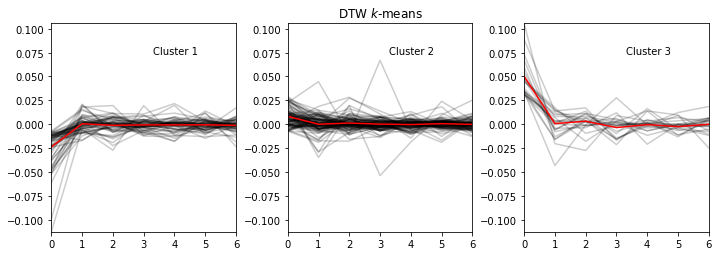

In [278]:
# DTW Visualisation
visualise_clustering(X_t, df_train['Return'])

### note: because the detrended data using log and moving average will result in extremely small values, which will lead
###       to similar cluster centroids more often than original data.

# IMPORTANT: Change THRESHOLD MULTIPLIER Here

In [279]:
# Find Threshold and save the value
Threshold = find_threshold(X_t, 1)

The max distance found is 0.17388074030106043 .
The inter-quartile range is 0.021578723057984067 .
The max-distance threshold for a new data point to be not classifed as an outlier is 0.17388074030106043 .
The full distance matrixs are with a size of 188 :
[0.01693644 0.02973782 0.03171735 0.03627625 0.01878524 0.02621388
 0.01741031 0.02439188 0.01087658 0.01627219 0.02042212 0.03052613
 0.02800109 0.02894793 0.0195283  0.02604538 0.03359615 0.02028531
 0.03012101 0.03574645 0.02213538 0.01787325 0.01719805 0.01758187
 0.0191013  0.02275605 0.03339539 0.04433413 0.03973235 0.02364074
 0.02748712 0.02127216 0.01352001 0.01980642 0.03655945 0.01781828
 0.03490193 0.04622775 0.12437712 0.09270116 0.06571032 0.05260312
 0.05593757 0.03003188 0.02833421 0.06398474 0.07283673 0.08410132
 0.05080243 0.17388074 0.12207123 0.16035547 0.0650494  0.15997944
 0.070893   0.07185541 0.08735093 0.09216053 0.07225069 0.04260315
 0.09080024 0.02726314 0.09705279 0.04229017 0.04024716 0.02216838
 0.027

# #################################

## DTW - Prediction

### Setting-up Testing Environment

# IMPORTANT: Change TESTING data INPUT Here

In [280]:
# Read AMC Testing Data
df_test = format_csv(r'Data\NOK_hr.csv')

# #################################

In [281]:
# Datetime Convertion
df_test.index = pd.to_datetime(df_test.index, utc = True)

In [282]:
# Remove Extra Data Points
df_test = df_test[~(df_test.index.date > pd.to_datetime('2021-02-11'))] ###

In [283]:
# Select the data to be predicted by the model: "Adj Close" or "Return" (Remember to drop nan when using detrended data)
X = df_test['Return'].dropna(inplace = False) ### DO NOT RENAME X or it will cause date report error!
print("The data going to apply to the testing model are:", X)

The data going to apply to the testing model are: Date
2020-09-30 13:30:00+00:00    0.000000
2020-09-30 14:30:00+00:00   -0.007557
2020-09-30 15:30:00+00:00    0.000051
2020-09-30 16:30:00+00:00   -0.000051
2020-09-30 17:30:00+00:00   -0.000888
                               ...   
2021-02-11 16:30:00+00:00   -0.008873
2021-02-11 17:30:00+00:00    0.004060
2021-02-11 18:30:00+00:00   -0.000901
2021-02-11 19:30:00+00:00    0.006559
2021-02-11 20:30:00+00:00   -0.006831
Name: Return, Length: 645, dtype: float64


In [284]:
# Setting up
mylist = iter(window(X, 7)) # Convert the np.Array into iterations to represent the streaming data environment.
X_lb = [] ### Create the Array for the result to be stored 

### Perform the Test to find Anomaly Pattern

In [285]:
# Single Exercution
# labeling_X(mylist, Threshold, X_lb)

In [286]:
# Fast Exercution
for i in range (len(list(window(X, 7)))): ###
    labeling_X(mylist, Threshold, X_lb)

The distance is: 0.027029258619258242
Time series:
[[ 0.00000000e+00]
 [-7.55666780e-03]
 [ 5.07698439e-05]
 [-5.07672665e-05]
 [-8.88320987e-04]
 [-5.46173256e-03]
 [-3.83138356e-03]]
is labeled as 0 .
Current labels are:
[0]
The distance is: 0.039193808784234174
Time series:
[[-7.55666780e-03]
 [ 5.07698439e-05]
 [-5.07672665e-05]
 [-8.88320987e-04]
 [-5.46173256e-03]
 [-3.83138356e-03]
 [-1.53846615e-02]]
is labeled as 0 .
Current labels are:
[0, 0]
The distance is: 0.041317053472491566
Time series:
[[ 5.07698439e-05]
 [-5.07672665e-05]
 [-8.88320987e-04]
 [-5.46173256e-03]
 [-3.83138356e-03]
 [-1.53846615e-02]
 [ 6.51044165e-03]]
is labeled as 0 .
Current labels are:
[0, 0, 0]
The distance is: 0.0408384617538852
Time series:
[[-5.07672665e-05]
 [-8.88320987e-04]
 [-5.46173256e-03]
 [-3.83138356e-03]
 [-1.53846615e-02]
 [ 6.51044165e-03]
 [-1.29369067e-03]]
is labeled as 0 .
Current labels are:
[0, 0, 0, 0]
The distance is: 0.04177253138404929
Time series:
[[-0.00088832]
 [-0.005461

[[ 0.00118615]
 [-0.00473933]
 [ 0.00833341]
 [ 0.00118055]
 [-0.00471698]
 [ 0.00521334]
 [-0.00518631]]
is labeled as 0 .
Current labels are:
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
The distance is: 0.030769091646962655
Time series:
[[-0.00473933]
 [ 0.00833341]
 [ 0.00118055]
 [-0.00471698]
 [ 0.00521334]
 [-0.00518631]
 [ 0.00118486]]
is labeled as 0 .
Current labels are:
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

The distance is: 0.0406365853170723
Time series:
[[-0.00530503]
 [ 0.00400003]
 [ 0.00796812]
 [-0.00131755]
 [-0.00791556]
 [ 0.00265957]
 [-0.00795755]]
is labeled as 0 .
Current labels are:
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
The distance is: 0.02997797513777553
Time series:
[[ 0.00400003]
 [ 0.00796812]
 [-0.00131755]
 [-0.00791556]
 [ 0.00265957]
 [-0.00795755]
 [ 0.00267379]]

The distance is: 0.0347348336337613
Time series:
[[-0.00615766]
 [ 0.00619581]
 [-0.0088916 ]
 [ 0.00648628]
 [-0.0012346 ]
 [-0.00247224]
 [ 0.        ]]
is labeled as 0 .
Current labels are:
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

The distance is: 0.028459384540976976
Time series:
[[-5.14224119e-05]
 [-3.80484124e-03]
 [ 7.74192810e-03]
 [ 1.28043905e-03]
 [ 3.83628290e-03]
 [ 0.00000000e+00]
 [-6.36939038e-03]]
is labeled as 0 .
Current labels are:
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

The distance is: 0.17155694045109676
Time series:
[[-0.00105266]
 [ 0.01180195]
 [ 0.00145802]
 [-0.00079033]
 [-0.01565299]
 [ 0.0763375 ]
 [ 0.06483299]]
is labeled as 0 .
Current labels are:
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [287]:
# Find the Anomalies
FindAnomaly(X_lb, 7) ###

Date: 2020-10-01 13:30:00+00:00
The p-value is: nan
No Anomlay Detected.
Date: 2020-10-01 14:30:00+00:00
The p-value is: nan
No Anomlay Detected.
Date: 2020-10-01 15:30:00+00:00
The p-value is: nan
No Anomlay Detected.
Date: 2020-10-01 16:30:00+00:00
The p-value is: nan
No Anomlay Detected.
Date: 2020-10-01 17:30:00+00:00
The p-value is: nan
No Anomlay Detected.
Date: 2020-10-01 18:30:00+00:00
The p-value is: nan
No Anomlay Detected.
Date: 2020-10-01 19:30:00+00:00
The p-value is: nan
No Anomlay Detected.
Date: 2020-10-02 13:30:00+00:00
The p-value is: nan
No Anomlay Detected.
Date: 2020-10-02 14:30:00+00:00
The p-value is: nan
No Anomlay Detected.
Date: 2020-10-02 15:30:00+00:00
The p-value is: nan
No Anomlay Detected.
Date: 2020-10-02 16:30:00+00:00
The p-value is: nan
No Anomlay Detected.
Date: 2020-10-02 17:30:00+00:00
The p-value is: nan
No Anomlay Detected.
Date: 2020-10-02 18:30:00+00:00
The p-value is: nan
No Anomlay Detected.
Date: 2020-10-02 19:30:00+00:00
The p-value is: nan

The p-value is: nan
No Anomlay Detected.
Date: 2020-12-18 20:30:00+00:00
The p-value is: nan
No Anomlay Detected.
Date: 2020-12-21 14:30:00+00:00
The p-value is: nan
No Anomlay Detected.
Date: 2020-12-21 15:30:00+00:00
The p-value is: nan
No Anomlay Detected.
Date: 2020-12-21 16:30:00+00:00
The p-value is: nan
No Anomlay Detected.
Date: 2020-12-21 17:30:00+00:00
The p-value is: nan
No Anomlay Detected.
Date: 2020-12-21 18:30:00+00:00
The p-value is: nan
No Anomlay Detected.
Date: 2020-12-21 19:30:00+00:00
The p-value is: nan
No Anomlay Detected.
Date: 2020-12-21 20:30:00+00:00
The p-value is: nan
No Anomlay Detected.
Date: 2020-12-22 14:30:00+00:00
The p-value is: nan
No Anomlay Detected.
Date: 2020-12-22 15:30:00+00:00
The p-value is: nan
No Anomlay Detected.
Date: 2020-12-22 16:30:00+00:00
The p-value is: nan
No Anomlay Detected.
Date: 2020-12-22 17:30:00+00:00
The p-value is: nan
No Anomlay Detected.
Date: 2020-12-22 18:30:00+00:00
The p-value is: nan
No Anomlay Detected.
Date: 2020

In [288]:
# Record the Anomalies & First Record of Anomaly Pattern
Anomaly = RecordAnomaly(X_lb, "Return", 7) ###
Anomaly_Table = pd.DataFrame(Anomaly)
display(Anomaly_Table) ### Just so it looks pretty!

,Date,Return
0,2020-10-28 18:30:00+00:00,0.002759
1,2020-10-28 19:30:00+00:00,-0.003686
2,2020-10-29 13:30:00+00:00,-0.183724
3,2020-10-29 14:30:00+00:00,-0.015106
4,2020-10-29 15:30:00+00:00,0.006135
5,2020-10-29 16:30:00+00:00,0.018293
6,2020-10-29 17:30:00+00:00,-0.005389
7,2021-01-27 14:30:00+00:00,0.076338
8,2021-01-27 15:30:00+00:00,0.064833
9,2021-01-27 16:30:00+00:00,0.226937


In [289]:
# Signal the First Instance
SignalAnomaly(X_lb, 7) ###

Timestamp('2020-10-28 18:30:00+0000', tz='UTC')

1st Anomaly Instance Detected at:                        Date    Return
0 2020-10-28 18:30:00+00:00  0.002759


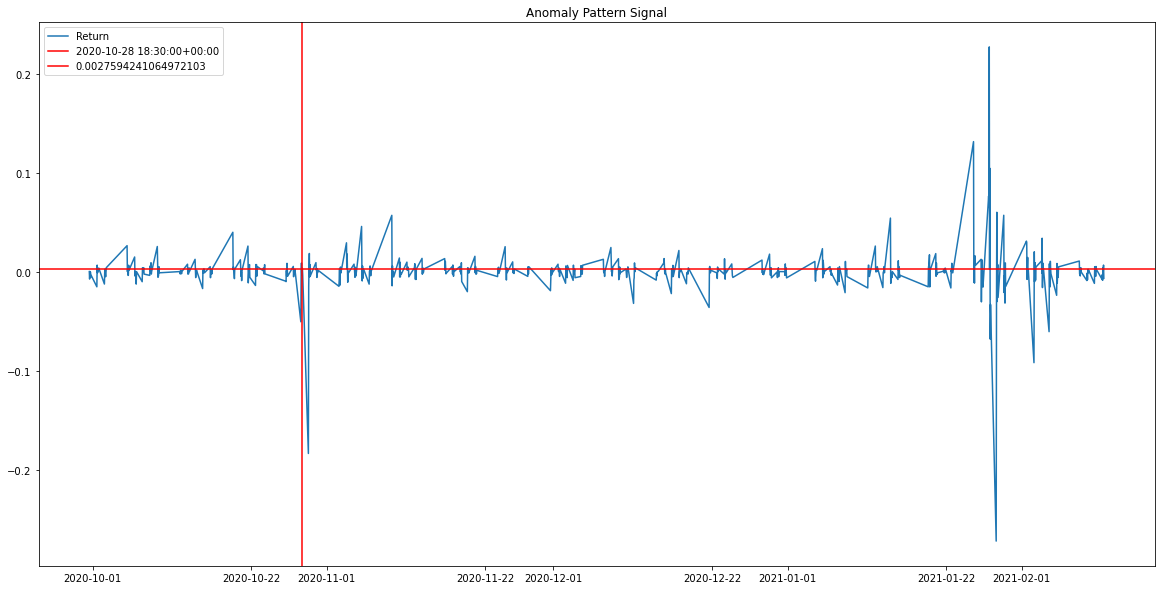

In [290]:
# Visulisation of the Anomaly Signal
plotAnomaly(df_test, "Return")

# Verification

In [291]:
# Check Date in Range for Reddit
def check_range_R(start, end):
    for i in range(len(Reddit_Anomaly['Date'])):
        if start <= Reddit_Anomaly['Date'][i] <= end:
            return 1

In [292]:
# Check Date in Range for Twitter
def check_range_T(start, end):
    for i in range(len(Twitter_Anomaly['Date'])):
        if start <= Twitter_Anomaly['Date'][i] <= end:
            return 1

In [293]:
# Check Date in Range for Crisis
def check_C(date):
    for i in range(len(crisis_period)):
        if crisis_period['Start'][i] <= date <= crisis_period['End'][i]:
            return 1

In [294]:
# Define Final Verification Function
def final_verify(data): ### Data = Anomaly_Table['Date']
    Date = []
    Reddit = []
    Twitter = []
    Crisis = []
    for i in range(len(data)):
        r = 0
        tw = 0
        start = data[i] - timedelta(weeks = 4)
        r = check_range_R(start, data[i])
        tw = check_range_T(start, data[i])
        if r == 1 or tw == 1:
            Date.append(data[i])
            Reddit.append(r)
            Twitter.append(tw)
    verified_anomaly = pd.DataFrame({'Date': Date, 'Reddit': Reddit, 'Twitter': Twitter})
    for i in range(len(verified_anomaly)):
        c = 0
        c = check_C(verified_anomaly['Date'][i])
        if c == 1:
            Crisis.append('Yes')
        else:
            Crisis.append('No')
    verified_anomaly['Crisis Environment'] = Crisis
    return verified_anomaly

## Obtain Final Result

In [295]:
# Get Result
final_result = final_verify(Anomaly_Table['Date'].dt.date) ###

In [296]:
# Check Result
final_result

,Date,Reddit,Twitter,Crisis Environment
0,2020-10-28,1,1,Yes
1,2020-10-28,1,1,Yes
2,2020-10-29,1,1,Yes
3,2020-10-29,1,1,Yes
4,2020-10-29,1,1,Yes
5,2020-10-29,1,1,Yes
6,2020-10-29,1,1,Yes
7,2021-01-27,1,1,Yes
8,2021-01-27,1,1,Yes
9,2021-01-27,1,1,Yes


# Evaluation

In [297]:
# def TP function
def TP(start_date):
    count = 0
    for i in range(len(Anomaly_Table)):
        if start_date <= Anomaly_Table['Date'].dt.date[i]: ###
            count = count + 1
    return count

In [227]:
# def FP function
def FP(start_date):
    count = 0
    for i in range(len(Anomaly_Table)):
        if Anomaly_Table['Date'].dt.date[i] <= start_date: ###
            count = count + 1
    return count

In [228]:
# def FN function
def AC(start_date, end_date):
    count = 0
    for i in range(len(X)):
        if start_date <= X.index[i] <= end_date:
            count = count + 1
    return count

In [229]:
# Def Metrics Result Function
def ev_metrics(): # Data = final_result['Date']
    start_date = datetime(2021,1,1).date() ###
    end_date = datetime(2021,1,31).date() ###
    Total = len(X)
    Anomalies = AC(start_date, end_date)
    tp = TP(start_date)
    fp = FP(start_date)
    fn = Anomalies - tp
    tn = Total - Anomalies - fp
    Accuracy = (tp + tn)/Total
    Percision = tp/(tp + fp)
    Recall = tp/(tp + fn)
    F = 2*(Percision * Recall)/(Percision + Recall)
    print("The evaluation metrics for the result are:")
    print("True Positive:" + str(tp))
    print("False Positive:" + str(fp))
    print("False Negative:" + str(fn))
    print("True Negative:" + str(tn))
    print("Total Number of Anomalies Present:" + str(Anomalies))
    print("Total Number of Data Tested:" + str(Total))
    print("#####################")
    print("Accuracy:" + str(Accuracy))
    print("Percision:" + str(Percision))
    print("Recall:" + str(Recall))
    print("F1-score:" + str(F))

In [230]:
# If No Result Found:
def ev_metrics2():
    start_date = datetime(2021,1,1).date() ###
    end_date = datetime(2021,1,31).date() ###
    Total = len(X)
    Anomalies = AC(start_date, end_date)
    print("Total Number of Anomalies Present:" + str(Anomalies))
    print("Total Number of Data Tested:" + str(Total))

## Metrics Result

In [298]:
# Obtain Evaluation Result
ev_metrics()

The evaluation metrics for the result are:
True Positive:13
False Positive:7
False Negative:120
True Negative:505
Total Number of Anomalies Present:133
Total Number of Data Tested:645
#####################
Accuracy:0.8031007751937984
Percision:0.65
Recall:0.09774436090225563
F1-score:0.16993464052287582


# Requirement Analysis

In [299]:
# Define Model Fit Function for Iteration Purpose
def DTWfit_i(X_t):
    model_X_temp = TimeSeriesKMeans(n_clusters = number_of_clusters, metric = algorithm, max_iter = 25)
    model_X_temp.fit(X_t) ### Fit the Model
    Xc = model_X_temp.cluster_centers_
    XL = model_X_temp.labels_
    s = min_size ### smallest cluster size
    idx = []
    for i in range(number_of_clusters): ### define functions to find clusters smaller than s
        if np.count_nonzero(XL == i) <= s:
            idx.append(i)
            print(len(idx), "cluster has a size smaller than", s, "and is removed.")
    Xc = np.delete(Xc, idx, axis = 0) ### remove clusters smaller than s
    if len(idx) == 0:
        model_X = model_X_temp
    else:
        model_X = TimeSeriesKMeans(n_clusters = len(Xc), metric = algorithm, max_iter = 25)
        model_X.fit(X_t) ### Fit the model again using updated cluster-size.
    return model_X

In [300]:
# Define Threshold Function for iteration
def find_th(X_t, m = 3): ### X_t is training dataset; m: multiplier (default is 3)
    XDM = []
    d_X = mod_X.cluster_centers_
    XL = mod_X.labels_
    for i in range (len(X_t)): # Compute Union of Distance Matrix
        j = XL[i]
        dist = dtw_dist(X_t[i], d_X[j]) 
        XDM.append(dist)
    q75, q25 = np.percentile(XDM, [75 ,25])
    iqr = q75 - q25 ### Compute inter-quartile range
    X_threshold = m * max(XDM) ### Define threshold using max-distance in traning data-set (three-scaled reference Diab et al.)
    print("The max distance found is", max(XDM), ".")
    return X_threshold

In [301]:
# Define Labelling Function Component for Iteration
def Labe(X_in, Thres): ### X_in: Streaming Input
    X_int = [X_in]
    d_X = mod_X.cluster_centers_
    j = mod_X.predict(X_int)[0]
    d = dtw_dist(np.reshape(X_in, (7,1)), d_X[j]) ###
    if d > Thres:
        return 1
    else:
        return 0

In [302]:
# Define lableing Function for iteration
def lab_X(inputs, threshold, X_l): ### inputs: Data to be detected, X_l: array to store the label
    nt = next(inputs, "Err")
    if isinstance(nt, str) == True:
        print ("no more value")
    else:
        nt = nt.reshape(7, 1) ###
        tl = Labe(nt, threshold)
        X_l.append(tl)

In [303]:
# Define Function that signals the first Anomaly Pattern Instance in January
def SignalAnomaly2(X_lb, size):
        if len(X_lb) < size:
            print("Not enough data.")
        else:
            ref_W = X_lb[0:size]
        for i in range(len(X_lb)-(size-1)):
            det_W = X_lb[i:i+size]
            pval = HT(ref_W, det_W)
            if pval < 0.05 and datetime(2021,1,1).date() < X.index[i+size]: ###
                return X.index[i+size] ###

In [304]:
# Define Count the Successful Detections Function
def countsucc(start_date = datetime(2021,1,1).date(), end_date = datetime(2021,1,25).date()): ###
    count = 0
    for i in range(len(signals)):
        if start_date <= signals[i].date() <= end_date:
            count = count + 1
    return count

## Obtain Requirement Evaluation Results

In [305]:
# Perform the Test
signals = []
for i in range(100):
    mod_X = DTWfit_i(X_t)
    Thres = find_th(X_t, 1)
    myli = iter(window(X, 7)) # Convert the np.Array into iterations to represent the streaming data environment. ###
    X_l = []
    for i in range (len(list(window(X, 7)))):
        lab_X(myli, Thres, X_l)
    signal = SignalAnomaly2(X_l, 7)
    signals.append(signal)

The max distance found is 0.1762565378105368 .
1 cluster has a size smaller than 9 and is removed.
The max distance found is 0.19290296330688184 .
The max distance found is 0.1699159707532225 .
The max distance found is 0.16853381223398856 .
The max distance found is 0.16853381223398856 .
The max distance found is 0.16853381223398856 .
1 cluster has a size smaller than 9 and is removed.
The max distance found is 0.1768721252835205 .
The max distance found is 0.16853381223398856 .
The max distance found is 0.1699159707532225 .
The max distance found is 0.17020874111265472 .
The max distance found is 0.16853381223398856 .
The max distance found is 0.17020874111265472 .
The max distance found is 0.17020874111265472 .
The max distance found is 0.16853381223398856 .
The max distance found is 0.17020874111265472 .
The max distance found is 0.16853381223398856 .
1 cluster has a size smaller than 9 and is removed.
The max distance found is 0.1768721252835205 .
The max distance found is 0.16853

In [309]:
# Display Results
signals

[Timestamp('2021-01-27 14:30:00+0000', tz='UTC'),
 Timestamp('2021-01-27 14:30:00+0000', tz='UTC'),
 Timestamp('2021-01-26 20:30:00+0000', tz='UTC'),
 Timestamp('2021-01-26 20:30:00+0000', tz='UTC'),
 Timestamp('2021-01-26 20:30:00+0000', tz='UTC'),
 Timestamp('2021-01-26 20:30:00+0000', tz='UTC'),
 Timestamp('2021-01-25 15:30:00+0000', tz='UTC'),
 Timestamp('2021-01-26 20:30:00+0000', tz='UTC'),
 Timestamp('2021-01-26 20:30:00+0000', tz='UTC'),
 Timestamp('2021-01-26 20:30:00+0000', tz='UTC'),
 Timestamp('2021-01-26 20:30:00+0000', tz='UTC'),
 Timestamp('2021-01-26 20:30:00+0000', tz='UTC'),
 Timestamp('2021-01-26 20:30:00+0000', tz='UTC'),
 Timestamp('2021-01-26 20:30:00+0000', tz='UTC'),
 Timestamp('2021-01-26 20:30:00+0000', tz='UTC'),
 Timestamp('2021-01-26 20:30:00+0000', tz='UTC'),
 Timestamp('2021-01-25 15:30:00+0000', tz='UTC'),
 Timestamp('2021-01-26 20:30:00+0000', tz='UTC'),
 Timestamp('2021-01-26 20:30:00+0000', tz='UTC'),
 Timestamp('2021-01-27 14:30:00+0000', tz='UTC'),


In [310]:
# Count
succ_count = countsucc()

In [311]:
# Display Results
succ_count

4